## 🌧️💨 **Merging AQI & Rainfall Data for Enhanced Analysis** 📊⚡  

This dataset combines **Air Quality Index (AQI)** data with **rainfall data** from the problem statement to analyze how precipitation impacts air pollution levels. By merging these datasets, we can explore trends, correlations, and potential effects of rain on air quality.

In [15]:
# Import Necessary Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


### 📂 Loading AQI & Rainfall Datasets
The following datasets are loaded for analysis:

🌫️ AQI Data: "dataset.csv" – Contains air quality measurements.

🌧️ Rainfall Data: "Rainfall_Data_LL.csv" – Includes precipitation levels.

These datasets will be merged to explore the impact of rainfall on air pollution.


In [16]:
# Load datasets
dataset_path1 = "../data/dataset.csv"
dataset_path2 = "../data/Rainfall_Data_LL.csv"

### 📂 Reading the Datasets
The AQI dataset is loaded from "dataset.csv" and contains air pollution data.

The Rainfall dataset is loaded from "Rainfall_Data_LL.csv" and includes precipitation records.

The ISO-8859-1 encoding is used to handle special characters in the data files.

In [17]:
# 📥 Load AQI and Rainfall Datasets
# Read the AQI dataset
df1 = pd.read_csv(dataset_path1, encoding='ISO-8859-1')

# Read the Rainfall dataset
df2 = pd.read_csv(dataset_path2, encoding='ISO-8859-1')


C:\Users\hp\AppData\Local\Temp\ipykernel_18096\662698617.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(dataset_path1, encoding='ISO-8859-1')


### 📅 Convert Date Column & Extract Year

- ✅ Convert the `date` column in the AQI dataset to datetime format.  
- 📆 Extract the `YEAR` column for merging with the Rainfall dataset.  


In [18]:
# Convert date column in AQI dataset to datetime format
df1["date"] = pd.to_datetime(df1["date"], errors="coerce")
# Extract year for merging
df1["YEAR"] = df1["date"].dt.year



### 🌍 Standardizing Location Names 

This process ensures that location names are consistently formatted by converting them to lowercase and removing any extra spaces. This helps in ensuring uniformity when comparing or merging data.


In [19]:
# Standardize location names (lowercase, stripped spaces)
df1["state"] = df1["state"].str.lower().str.strip()
df1["location"] = df1["location"].str.lower().str.strip()
df2["SUBDIVISION"] = df2["SUBDIVISION"].str.lower().str.strip()

### 🔄 Merging Datasets and Dropping Unnecessary Columns 

This process merges two datasets (`df1` and `df2`) based on matching values from specified columns and then removes any unneeded columns to clean up the resulting dataframe.

#### Merging Explanation :

We are merging `df1` and `df2` on two common columns: 
- `state` from `df1` and `SUBDIVISION` from `df2` 
- `YEAR` from both datasets

In [20]:
# Merge datasets on state and year
merged_df = df1.merge(df2, how="left", left_on=["state", "YEAR"], right_on=["SUBDIVISION", "YEAR"])

# Drop unnecessary columns
merged_df = merged_df.drop(columns=["SUBDIVISION", "Name"], errors='ignore')


### 📊 AQI Calculation Method  

The following function calculates the **Air Quality Index (AQI)** based on major pollutants using **Central Pollution Control Board (CPCB) breakpoints**.  

#### 🛠️ Methodology:  
- The function takes a row of pollutant data as input.  
- It checks pollutant concentrations against predefined **breakpoints** (ranges for different AQI levels).  
- The **sub-index** for each pollutant is calculated using linear interpolation.  
- The **maximum sub-index** among all pollutants is taken as the final AQI.  

In [21]:
# CPCB AQI Calculation using all major pollutants
def calculate_aqi(row):
    breakpoints = {
        'pm2_5': [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), (91, 120, 201, 300), (121, 250, 301, 400)],
        'pm10': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), (251, 350, 201, 300), (351, 430, 301, 400)],
        'no2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), (181, 280, 201, 300), (281, 400, 301, 400)],
        'so2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200), (381, 800, 201, 300), (801, 1600, 301, 400)],
        'co': [(0, 1, 0, 50), (1.1, 2, 51, 100), (2.1, 10, 101, 200), (10.1, 17, 201, 300), (17.1, 34, 301, 400)],
        'o3': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200), (169, 208, 201, 300), (209, 748, 301, 400)]
    }
    
    sub_indices = []
    for pollutant, bps in breakpoints.items():
        if pollutant in row:
            value = row[pollutant]
            for c_low, c_high, i_low, i_high in bps:
                if c_low <= value <= c_high:
                    sub_index = ((i_high - i_low) / (c_high - c_low)) * (value - c_low) + i_low
                    sub_indices.append(sub_index)
                    break
    
    return max(sub_indices) if sub_indices else np.nan
# Apply AQI calculation to dataset
merged_df['AQI'] = merged_df.apply(calculate_aqi, axis=1)

### 🌧️ Feature Engineering: Total Annual Rainfall 

#### 🔍 Description:
The rainfall feature represents the total annual rainfall for each location by summing up monthly rainfall values from January to December. This provides a yearly aggregate measure of precipitation at a given location.

In [22]:
# Calculate total yearly rainfall by summing monthly values
merged_df['rainfall'] = merged_df[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 
                                   'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].sum(axis=1)


### Calculating Pearson Correlation Between Rainfall and AQI 🌧️📊

After cleaning and merging the datasets, it's time to calculate the Pearson correlation between the `rainfall` and `AQI` columns to understand their relationship.

#### Pearson Correlation Calculation 🔗

We use the **Pearson correlation** coefficient to measure the linear relationship between `rainfall` and `AQI`. 

This value ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no linear relationship.


In [23]:
# Calculate the Pearson correlation between 'rainfall' and 'AQI'
correlation = merged_df["rainfall"].corr(merged_df["AQI"])
print(f"Pearson correlation after cleaning: {correlation:.3f}")

# showing all the column of merged dataset
print(merged_df.columns)

Pearson correlation after cleaning: -0.177
Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date', 'YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG',
       'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL', 'Jan-Feb', 'Mar-May',
       'June-September', 'Oct-Dec', 'Latitude', 'Longitude', 'AQI',
       'rainfall'],
      dtype='object')


### 📊 AQI Distribution Analysis

#### 🔍 Description:
This plot visualizes the **distribution of AQI (Air Quality Index)**, helping to understand how air quality varies across different locations and time periods. It also identifies common AQI ranges and potential outliers.

Index (AQI)", fontsize=12)  # X-axis: AQI values
plt.ylabel("Frequency", fontsize=12)  # Y-axis: Count of occurrences



#### 📌 Explanation of Axes:
- **X-axis (Air Quality Index - AQI) 📏**  
  Represents the AQI values, showing different levels of air pollution. Lower values indicate better air quality, while higher values suggest poor air conditions.
  
- **Y-axis (Frequency 📊)**  
  Represents the number of occurrences (or frequency) of each AQI range in the dataset. The taller bars indicate AQI values that appear more frequently.

#### 📊 Key Insights:
- **Peak Values:** The most common AQI ranges can be observed from the highest bars.
- **Distribution Shape:** If the histogram is **skewed right**, it indicates more high-AQI (polluted) cases.
- **Outliers Detection:** Any extreme values (far-right bars) can signal air pollution spikes.

🚀 This is a crucial **Exploratory Data Analysis (EDA)** step before building predictive models! Let me know if you need any adjustments. 🔥

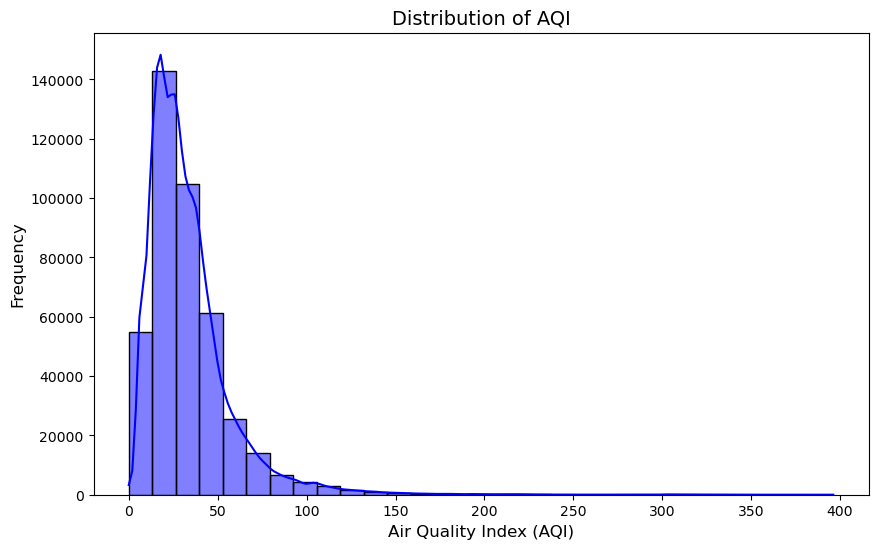

In [24]:


# Plot a histogram of AQI values with Kernel Density Estimation (KDE)
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['AQI'], bins=30, kde=True, color='blue')

# Labels and title
plt.title("Distribution of AQI", fontsize=14)
plt.xlabel("Air Quality Index (AQI)", fontsize=12)  # X-axis: AQI values
plt.ylabel("Frequency", fontsize=12)  # Y-axis: Count of occurrences

# Display the plot
plt.show()


### 🌧️ Rainfall vs. AQI Analysis

#### 🔍 Description:
This plot examines the relationship between rainfall and AQI (Air Quality Index) using a regression trend line. It helps determine whether increased rainfall is associated with better air quality (lower AQI).

####  Explanation:
X-axis: Rainfall (mm) 
Y-axis: AQI (Air Quality Index) 
Red Line: Shows the trend (correlation between rainfall & AQI).

####  Key Insight:
 The trend slopes downward, suggesting rainfall may help reduce pollution by washing away airborne particles.

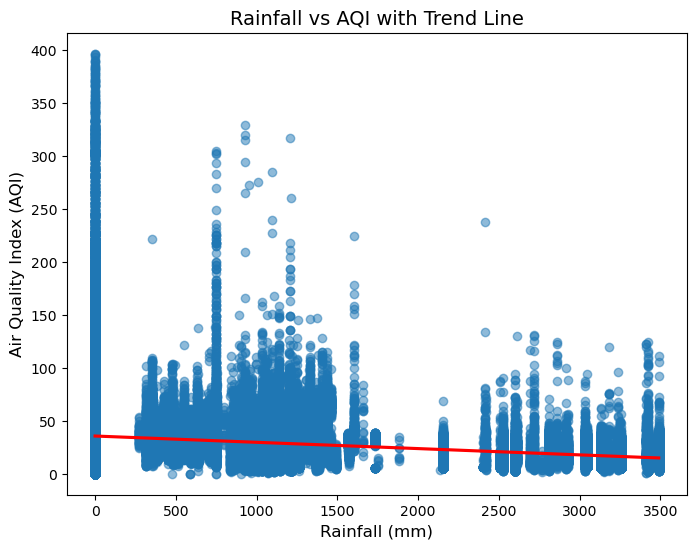

In [25]:

# Set figure size for better readability
plt.figure(figsize=(8, 6))

# Scatter plot with regression line
sns.regplot(x=merged_df["rainfall"], y=merged_df["AQI"], 
            scatter_kws={'alpha': 0.5},  # Adjust transparency for clarity
            line_kws={'color': 'red'})  # Regression line in red

# Add labels and title
plt.title("Rainfall vs AQI with Trend Line", fontsize=14)
plt.xlabel("Rainfall (mm)", fontsize=12)  # X-axis: Total Rainfall in mm
plt.ylabel("Air Quality Index (AQI)", fontsize=12)  # Y-axis: AQI values

# Display the plot
plt.show()


### 🌦️ AQI During Monsoon & Non-Monsoon Seasons
#### 🔍 Description:
This boxplot compares the Air Quality Index (AQI) during monsoon and non-monsoon seasons. It helps analyze whether rainfall has a significant impact on air pollution levels.
#### 📌 Explanation:
X-axis: Monsoon season categories (Monsoon or Non-Monsoon)
Y-axis: Air Quality Index (AQI)
Boxplot: Shows AQI distribution for both seasons

#### 📊 Key Insight:
AQI tends to be lower during the monsoon season, suggesting that rainfall helps improve air quality by reducing airborne pollutants. 

C:\Users\hp\AppData\Local\Temp\ipykernel_18096\1027891826.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='monsoon_season', y='AQI', data=merged_df, palette='Set2')


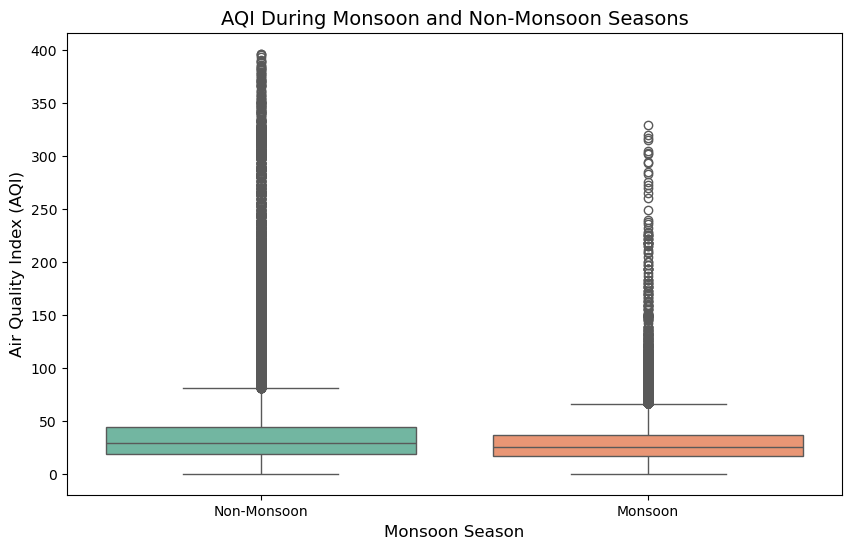

In [26]:


# Compute total monsoon rainfall (sum of June, July, August, and September)
merged_df['monsoon_rain'] = merged_df[['JUN', 'JUL', 'AUG', 'SEP']].sum(axis=1)

# Create a new column indicating whether it's monsoon season or not
merged_df['monsoon_season'] = merged_df['monsoon_rain'].apply(lambda x: 'Monsoon' if x > 0 else 'Non-Monsoon')

# Set up the plot
plt.figure(figsize=(10, 6))

# Create a boxplot to compare AQI during monsoon and non-monsoon seasons
sns.boxplot(x='monsoon_season', y='AQI', data=merged_df, palette='Set2')

# Add labels and title
plt.title('AQI During Monsoon and Non-Monsoon Seasons', fontsize=14)
plt.xlabel('Monsoon Season', fontsize=12)
plt.ylabel('Air Quality Index (AQI)', fontsize=12)

# Display the plot
plt.show()


### 📊 Correlation Matrix of Variables
#### 🔍 Description:
This heatmap visualizes the correlation between key environmental variables, including rainfall, AQI, monsoon rainfall, and pollutants (SO₂, NO₂, RSPM, PM2.5). It helps identify relationships between these factors.
#### 📌 Explanation:
Color Scale:

🔵 Negative correlation (blue) → One variable increases, the other decreases.

🔴 Positive correlation (red) → Both variables increase together.

Key Variables:

Rainfall & AQI: Indicates how rain affects air quality.

Monsoon Rain & Pollutants: Shows seasonal pollution trends.

#### 📊 Key Insight:
This heatmap reveals how rainfall and monsoon influence air pollution levels, helping to identify patterns in air quality changes.

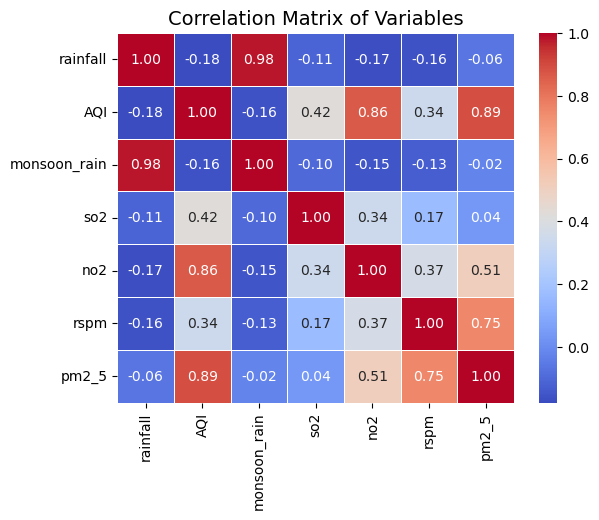

In [27]:
# Compute correlation matrix
correlation_matrix = merged_df[['rainfall', 'AQI', 'monsoon_rain', 'so2', 'no2', 'rspm', 'pm2_5']].corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title
plt.title('Correlation Matrix of Variables', fontsize=14)

# Display the plot
plt.show()

### 💾 Saving the Merged Dataset and Displaying Sample Output 

After merging the datasets and cleaning up the columns, it's time to save the result and inspect a sample of the output.

#### Saving the Merged Dataset :

We save the merged dataframe (`merged_df`) as a CSV file for future use.

In [28]:
# Save merged dataset
merged_df.to_csv("../data/merged_dataset.csv", index=False)

# Display sample output
print(merged_df.head())

# This will show all the column names in the merged dataframe
print(merged_df.columns)

  stn_code       sampling_date           state   location agency  \
0    150.0  February - M021990  andhra pradesh  hyderabad    NaN   
1    151.0  February - M021990  andhra pradesh  hyderabad    NaN   
2    152.0  February - M021990  andhra pradesh  hyderabad    NaN   
3    150.0     March - M031990  andhra pradesh  hyderabad    NaN   
4    151.0     March - M031990  andhra pradesh  hyderabad    NaN   

                                 type  so2   no2  rspm  spm  ... Jan-Feb  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN  ...     NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN  ...     NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN  ...     NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN  ...     NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN  ...     NaN   

   Mar-May June-September  Oct-Dec  Latitude  Longitude     AQI  rainfall  \
0      NaN            NaN      NaN       NaN        NaN  